# Postprocessing and Model Building

In [1]:
import os
import pickle
import json
from sklearn.metrics import mean_squared_error
import numpy as np
import seaborn as sns

In [2]:
main_filepath = '/sietch_colab/akapoor/Demographic_Inference'

CONFIG_FILEPATH = f'{main_filepath}/experiment_config.json'
MODEL_CONFIG_FILEPATH = f'{main_filepath}/model_config.json'

with open(CONFIG_FILEPATH, 'r') as f:
   experiment_config = json.load(f)

with open(MODEL_CONFIG_FILEPATH, 'r') as f:
   model_config = json.load(f)


CWD = os.getcwd()

# Use double quotes for the dictionary keys inside the f-string
EXPERIMENT_DIRECTORY = f"{experiment_config['demographic_model']}_dadi_analysis_{experiment_config['dadi_analysis']}_moments_analysis_{experiment_config['moments_analysis']}_momentsLD_analysis_{experiment_config['momentsLD_analysis']}_seed_{experiment_config['seed']}"
EXPERIMENT_NAME = f'sims_pretrain_{experiment_config["num_sims_pretrain"]}_sims_inference_{experiment_config["num_sims_inference"]}_seed_{experiment_config["seed"]}_num_replicates_{experiment_config["k"]}_top_values_{experiment_config["top_values_k"]}'
SIM_DIRECTORY = f"{EXPERIMENT_DIRECTORY}/sims/{EXPERIMENT_NAME}"

# Check if hidden_size is a list, and if so, join the elements with "_"
hidden_size = model_config['neural_net_hyperparameters']['hidden_size']
if isinstance(hidden_size, list):
    hidden_size_str = "_".join(map(str, hidden_size))  # Join list elements with "_"
else:
    hidden_size_str = str(hidden_size)  # Convert integer to string if not a list

# Build the MODEL_DIRECTORY string
MODEL_DIRECTORY = (
    f"{EXPERIMENT_DIRECTORY}/models/{EXPERIMENT_NAME}/"
    f"num_hidden_neurons_{hidden_size_str}_"
    f"num_hidden_layers_{model_config['neural_net_hyperparameters']['num_layers']}_"
    f"num_epochs_{model_config['neural_net_hyperparameters']['num_epochs']}_"
    f"dropout_value_{model_config['neural_net_hyperparameters']['dropout_rate']}_"
    f"weight_decay_{model_config['neural_net_hyperparameters']['weight_decay']}_"
    f"batch_size_{model_config['neural_net_hyperparameters']['batch_size']}_"
    f"EarlyStopping_{model_config['neural_net_hyperparameters']['EarlyStopping']}"
)


In [3]:
os.chdir('/sietch_colab/akapoor/Demographic_Inference/')
os.environ['PYTHONPATH'] = '/sietch_colab/akapoor/Demographic_Inference:' + os.environ.get('PYTHONPATH', '')

Just to check again, I want to look at the results for preprocessing

In [4]:
with open(os.path.join('/sietch_colab/akapoor/Demographic_Inference',f'{SIM_DIRECTORY}', 'preprocessing_results_obj.pkl'), 'rb') as f:
    preproc = pickle.load(f)

In [5]:
preproc['training']['indices'][0]

4227

In [6]:
preproc['training']['predictions'].columns

Index(['dadi_rep1_N0', 'moments_rep1_N0', 'moments_rep1_FIM_element_0',
       'moments_rep1_FIM_element_1', 'moments_rep1_FIM_element_2',
       'moments_rep1_FIM_element_3', 'moments_rep1_FIM_element_4',
       'moments_rep1_FIM_element_5', 'dadi_rep1_Nb', 'moments_rep1_Nb',
       'dadi_rep1_N_recover', 'moments_rep1_N_recover',
       'dadi_rep1_t_bottleneck_end', 'moments_rep1_t_bottleneck_end',
       'dadi_rep2_N0', 'moments_rep2_N0', 'moments_rep2_FIM_element_0',
       'moments_rep2_FIM_element_1', 'moments_rep2_FIM_element_2',
       'moments_rep2_FIM_element_3', 'moments_rep2_FIM_element_4',
       'moments_rep2_FIM_element_5', 'dadi_rep2_Nb', 'moments_rep2_Nb',
       'dadi_rep2_N_recover', 'moments_rep2_N_recover',
       'dadi_rep2_t_bottleneck_end', 'moments_rep2_t_bottleneck_end',
       'momentsLD_N0', 'momentsLD_Nb', 'momentsLD_N_recover',
       'momentsLD_t_bottleneck_end'],
      dtype='object')

In [7]:
import pandas as pd

# Assuming preproc['training']['predictions'] is a DataFrame
predictions_df = preproc['training']['predictions']

# Count rows with at least one NaN value
rows_with_nan = predictions_df.isna().any(axis=1).sum()

print(f"Number of rows with at least one NaN value: {rows_with_nan}")


Number of rows with at least one NaN value: 0


In [8]:
preproc['training']['predictions']['moments_rep1_N0']

0       8328.334400
1       9731.170513
2       8683.820747
3       8778.802999
4       8948.805914
           ...     
3995    8015.847400
3996    8083.078998
3997    9264.042337
3998    9335.727717
3999    9334.574117
Name: moments_rep1_N0, Length: 4000, dtype: float64

In [9]:
np.max(preproc['training']['targets']['simulated_params_N0'])

9999

In [10]:
np.min(preproc['training']['targets']['simulated_params_N0'])

8000

In [11]:
preproc['training']['targets']['simulated_params_N0']

0       8320
1       9673
2       8660
3       8746
4       8888
        ... 
3995    8020
3996    8133
3997    9278
3998    9303
3999    9375
Name: simulated_params_N0, Length: 4000, dtype: int64

In [12]:
preproc['training']['predictions']['dadi_rep1_N0']

0       8332.220122
1       9735.511851
2       8683.031259
3       8785.589683
4       8951.790406
           ...     
3995    8024.092313
3996    8084.872121
3997    9268.811540
3998    9340.738048
3999    9339.530233
Name: dadi_rep1_N0, Length: 4000, dtype: float64

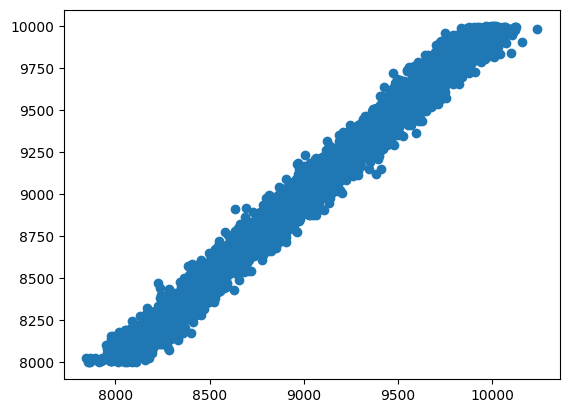

In [13]:
import matplotlib.pyplot as plt
plt.scatter(preproc['training']['predictions']['moments_rep1_N0'], preproc['training']['targets']['simulated_params_N0'])
# Set the zoomed-in range for the axes
# # Show the zoomed-in plot
# plt.show()
plt.show()

## Postprocessing

In [14]:
!python /sietch_colab/akapoor/Demographic_Inference/snakemake_scripts/postprocessing.py \
    --config_file $CONFIG_FILEPATH \
    --training_features_filepath $SIM_DIRECTORY/training_features.csv \
    --training_targets_filepath $SIM_DIRECTORY/training_targets.csv \
    --validation_features_filepath $SIM_DIRECTORY/validation_features.csv \
    --validation_targets_filepath $SIM_DIRECTORY/validation_targets.csv \
    --sim_directory $SIM_DIRECTORY



Processing training data:
===> Normalizing the data.

Processing validation data:
===> Normalizing the data.
Postprocessing dict keys: dict_keys(['normalization', 'predictions', 'normalized_predictions', 'targets', 'normalized_targets'])
Postprocessing complete!


In [15]:
with open(os.path.join('/sietch_colab/akapoor/Demographic_Inference',f'{SIM_DIRECTORY}', 'postprocessing_results.pkl'), 'rb') as f:
    post = pickle.load(f)

In [16]:
post['training']['normalized_predictions']['dadi_rep1_t_bottleneck_end']

0       4.616103
1       1.740663
2      -2.626260
3      -6.458205
4       4.773928
          ...   
3995   -3.187464
3996   -3.921154
3997   -3.427263
3998    7.061629
3999    6.125171
Name: dadi_rep1_t_bottleneck_end, Length: 4000, dtype: float64

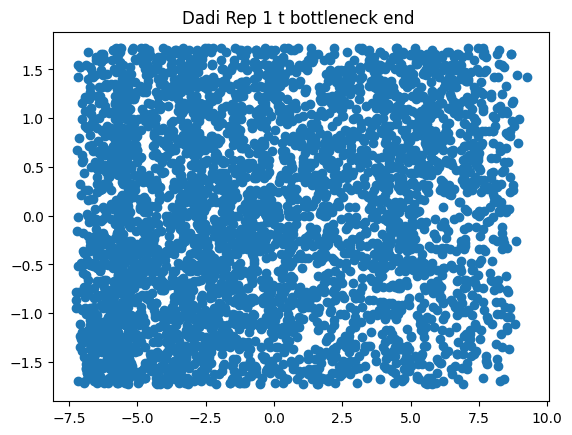

In [17]:
plt.figure()
plt.title("Dadi Rep 1 t bottleneck end ")
plt.scatter(post['training']['normalized_predictions']['dadi_rep1_t_bottleneck_end'], post['training']['normalized_targets']['simulated_params_t_bottleneck_end'])
plt.show()

## Calculate the MSE for each analysis type and for each stage.

In [18]:
post['training']['normalized_predictions']

,dadi_rep1_N0,moments_rep1_N0,moments_rep1_FIM_element_0,moments_rep1_FIM_element_1,moments_rep1_FIM_element_2,moments_rep1_FIM_element_3,moments_rep1_FIM_element_4,moments_rep1_FIM_element_5,dadi_rep1_Nb,moments_rep1_Nb,...,dadi_rep2_Nb,moments_rep2_Nb,dadi_rep2_N_recover,moments_rep2_N_recover,dadi_rep2_t_bottleneck_end,moments_rep2_t_bottleneck_end,momentsLD_N0,momentsLD_Nb,momentsLD_N_recover,momentsLD_t_bottleneck_end
0,-1.156629,-1.163359,0.633325,0.013137,1.070448,-0.030264,-1.376227,0.275692,-2.090425,-1.957803,...,-2.090422,-1.957803,0.117033,0.024037,4.616101,4.606680,-0.661291,2.354240,4.795701,-9.367692
1,1.273944,1.266424,-0.312813,0.994429,0.070430,-0.334302,0.374891,0.219778,-0.948273,-0.745117,...,-0.948273,-0.747675,2.328917,2.160618,1.740663,1.925076,1.486016,1.585594,4.520429,-9.851780
2,-0.549006,-0.547639,0.785296,-0.880350,0.601306,0.463157,-0.330648,0.596905,0.021470,0.431413,...,0.060094,0.431004,1.217491,0.849507,-2.412649,-1.441822,0.799337,11.305435,-2.702889,-5.079854
3,-0.371370,-0.383124,-0.702818,-1.309839,-1.338795,1.422382,-0.091657,-1.073644,-1.066740,-0.893117,...,-1.066683,-0.893922,3.012158,2.563135,-6.458212,-6.465295,-0.855719,4.663410,-0.828335,-12.603631
4,-0.083501,-0.088671,0.790385,0.518531,0.938689,-1.021171,-0.381558,0.844293,1.770680,1.971286,...,1.764477,1.940142,-1.098090,-1.164834,4.756120,5.127461,0.367382,-6.446438,-0.827639,8.194831
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,-1.690322,-1.704602,0.278570,-1.352652,-0.025914,1.387708,-1.508798,-0.434497,-1.056091,-0.959352,...,-1.056100,-0.959378,2.499985,2.474260,-3.187421,-3.675214,-1.175257,0.907074,6.545274,-8.368436
3996,-1.585048,-1.588154,0.483476,-1.335489,0.152950,1.218017,-1.178714,0.367737,-0.672882,-0.499536,...,-0.669063,-0.499532,1.785923,1.368717,-3.921075,-3.516225,-1.469465,3.442878,6.394211,-8.754525
3997,0.465595,0.457335,-0.961258,0.368297,-0.916342,0.263615,0.862351,0.146386,-2.092091,-1.889396,...,-2.092121,-1.889396,0.639209,0.351348,-3.427327,-3.203537,-0.237831,34.892516,-2.113856,28.180965
3998,0.590176,0.581497,0.333460,1.346261,0.855989,-1.451560,-0.267828,0.613026,0.045806,0.173049,...,0.045559,0.173049,-0.545237,-0.597353,7.061670,7.049479,0.251900,-3.593022,0.781205,1.556069


In [19]:
post['training']['normalized_predictions']['dadi_rep1_N0']

0      -1.156629
1       1.273944
2      -0.549006
3      -0.371370
4      -0.083501
          ...   
3995   -1.690322
3996   -1.585048
3997    0.465595
3998    0.590176
3999    0.588084
Name: dadi_rep1_N0, Length: 4000, dtype: float64

In [20]:
mean_squared_error(post['training']['normalized_predictions']['dadi_rep1_N0'], post['training']['normalized_targets']['simulated_params_N0'])

0.016217162734803618

In [21]:
np.min(post['training']['normalized_predictions']['dadi_rep1_N0'])

-1.9895573362790475

In [22]:
mean_squared_error(post['training']['normalized_predictions']['dadi_rep1_Nb'], post['training']['normalized_targets']['simulated_params_Nb'])

1.8786598554324179

In [23]:
np.max(post['training']['normalized_predictions']['dadi_rep1_Nb'])

8.067030435537289

In [24]:
post['training']['normalized_targets']['simulated_params_Nb']

0       0.103923
1       1.427210
2       1.368320
3       0.360267
4       0.862561
          ...   
3995   -0.460726
3996   -1.326751
3997   -0.173205
3998   -0.374123
3999    1.538061
Name: simulated_params_Nb, Length: 4000, dtype: float64

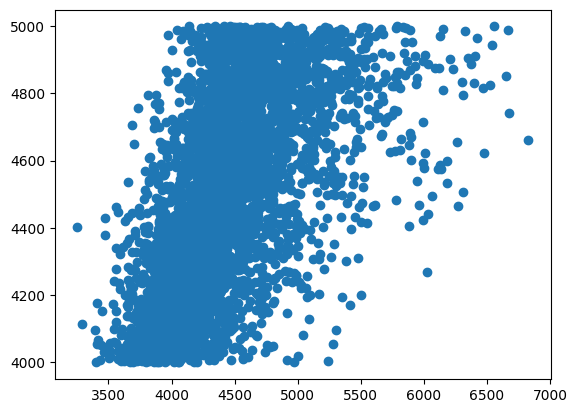

In [25]:
import matplotlib.pyplot as plt
plt.scatter(preproc['training']['predictions']['dadi_rep1_Nb'], preproc['training']['targets']['simulated_params_Nb'])

In [26]:
def plot_mse_and_sem(mse_results, sem_results, title, parameters):
    """
    Create a grouped bar plot showing MSE values with error bars for each parameter and analysis type.
    
    Parameters:
    -----------
    mse_results : dict
        Dictionary containing MSE values for each analysis type and parameter
    sem_results : dict
        Dictionary containing SEM values for each analysis type and parameter
    title : str
        Title for the plot
    parameters : list
        List of parameter names to plot
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Create figure and axis with clean style
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Number of parameter groups and analysis types
    n_parameters = len(parameters)
    n_analyses = len(mse_results.keys())
    
    # Width of each bar and positions of the bars
    bar_width = 0.25
    index = np.arange(n_parameters)
    
    # Colors for different analysis types - using more distinct colors
    colors = ['#2ecc71', '#3498db', '#e74c3c']  # green, blue, red
    
    # Plot bars for each analysis type
    for i, (analysis_type, color) in enumerate(zip(mse_results.keys(), colors)):
        mse_values = []
        sem_values = []
        for param in parameters:
            mse_values.append(mse_results[analysis_type].get(param, 0))
            sem_values.append(sem_results[analysis_type].get(param, 0))
        
        positions = index + (i - 1) * bar_width
        bars = ax.bar(positions, mse_values, bar_width,
                     label=analysis_type, color=color, alpha=0.8)
        
        # Add error bars
        ax.errorbar(positions, mse_values, yerr=sem_values,
                   fmt='none', color='black', capsize=5)
    
    # Customize the plot
    ax.set_ylabel('Mean Squared Error (MSE)', fontsize=10)
    ax.set_title(title, fontsize=12, pad=20)
    ax.set_xticks(index)
    ax.set_xticklabels(parameters, fontsize=10)
    
    # Add legend with better positioning
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Rotate x-axis labels if needed
    plt.xticks(rotation=45)
    
    # Add grid with light color
    ax.yaxis.grid(True, linestyle='--', alpha=0.3, color='gray')
    
    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    
    return fig

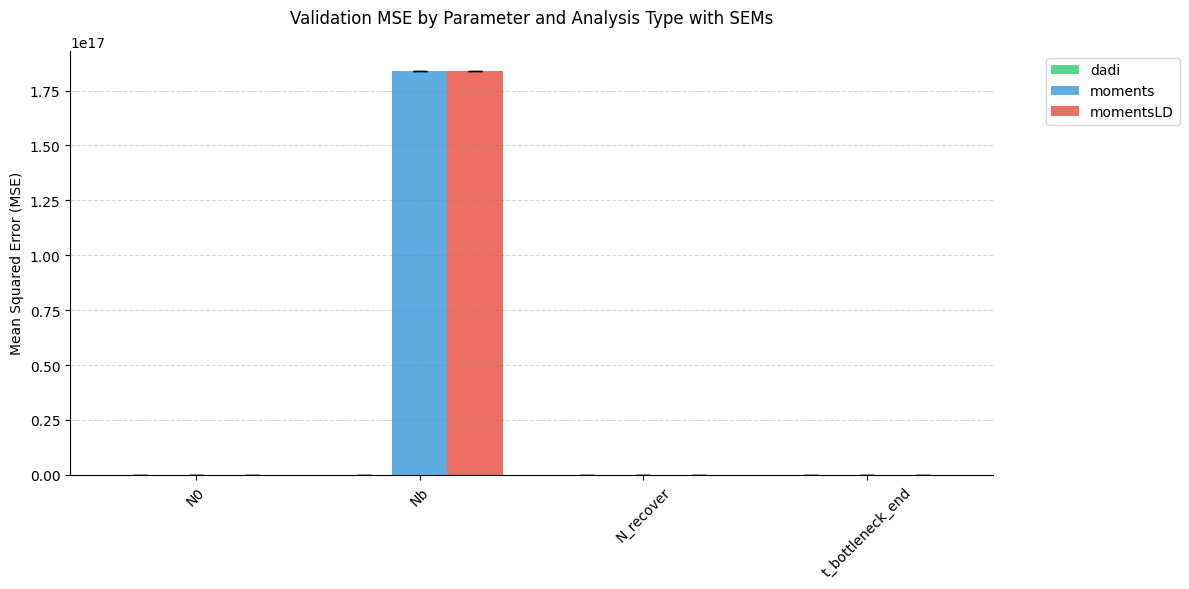

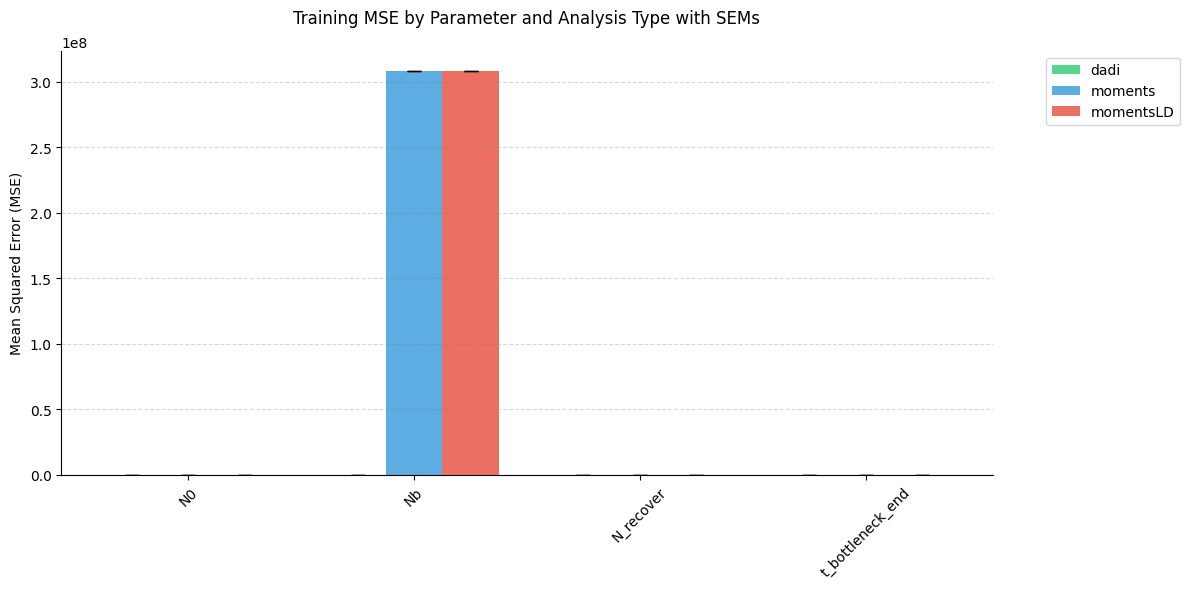

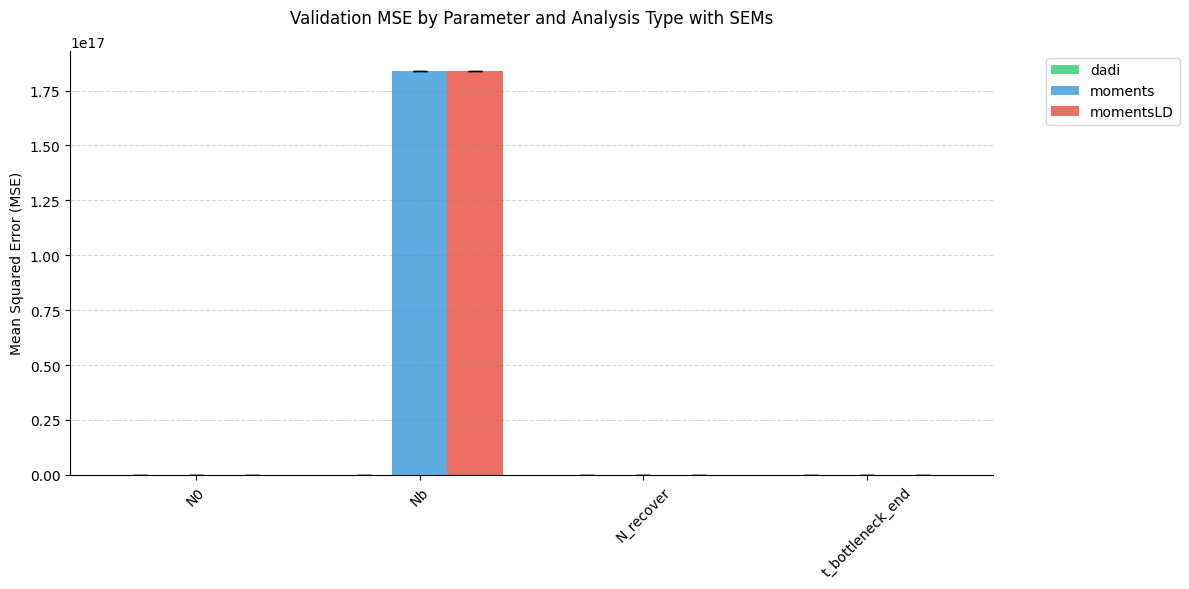

In [27]:
# Updated function to handle underscores in parameter names correctly
def calculate_mse_and_sem(post, key):
    predictions = post[key]['normalized_predictions']
    targets = post[key]['normalized_targets']
    mse_results = {}
    sem_results = {}

    for analysis_type in ['dadi', 'moments', 'momentsLD']:
        mse_values = {}
        sem_values = {}
        for column in predictions.columns:
            if column.startswith(analysis_type):
                # Extract parameter name after the last '_'
                param_name = "_".join(column.split('_')[-2:]) if 't_split' in column else column.split('_')[-1]
                target_column = f"simulated_params_{param_name}"
                if target_column in targets.columns:
                    mse = mean_squared_error(targets[target_column], predictions[column])
                    mse_values[param_name] = mse
                    sem = np.std(targets[target_column] - predictions[column]) / np.sqrt(len(targets[target_column]))
                    sem_values[param_name] = sem
        if mse_values:
            mse_results[analysis_type] = mse_values
            sem_results[analysis_type] = sem_values
    return mse_results, sem_results

# Parameters list
# parameters = ['Na', 'N1', 'N2', "t_split"]
parameters = experiment_config['parameters_to_estimate']

# Recalculate MSE and SEM for training and validation with the updated function
training_mse, training_sem = calculate_mse_and_sem(post, 'training')
validation_mse, validation_sem = calculate_mse_and_sem(post, 'validation')

# Re-plot with the fixed parameter handling
plot_mse_and_sem(training_mse, training_sem, "Training MSE by Parameter and Analysis Type with SEMs", parameters)
plot_mse_and_sem(validation_mse, validation_sem, "Validation MSE by Parameter and Analysis Type with SEMs", parameters)

In [28]:
training_mse

{'dadi': {'N0': 0.016214304782781908, 'Nb': 1.8654618850752627},
 'moments': {'N0': 68.90109253684578, 'Nb': 308292074.65493345},
 'momentsLD': {'N0': 68.90109253684578, 'Nb': 308292074.65493345}}

In [29]:
validation_mse

{'dadi': {'N0': 0.01610100689796418, 'Nb': 1.9783192228174216},
 'moments': {'N0': 152.2146763862601, 'Nb': 1.8389841749703555e+17},
 'momentsLD': {'N0': 152.2146763862601, 'Nb': 1.8389841749703555e+17}}

In [30]:
post['training']['predictions'].columns

Index(['dadi_rep1_N0', 'moments_rep1_N0', 'moments_rep1_FIM_element_0',
       'moments_rep1_FIM_element_1', 'moments_rep1_FIM_element_2',
       'moments_rep1_FIM_element_3', 'moments_rep1_FIM_element_4',
       'moments_rep1_FIM_element_5', 'dadi_rep1_Nb', 'moments_rep1_Nb',
       'dadi_rep1_N_recover', 'moments_rep1_N_recover',
       'dadi_rep1_t_bottleneck_end', 'moments_rep1_t_bottleneck_end',
       'dadi_rep2_N0', 'moments_rep2_N0', 'moments_rep2_FIM_element_0',
       'moments_rep2_FIM_element_1', 'moments_rep2_FIM_element_2',
       'moments_rep2_FIM_element_3', 'moments_rep2_FIM_element_4',
       'moments_rep2_FIM_element_5', 'dadi_rep2_Nb', 'moments_rep2_Nb',
       'dadi_rep2_N_recover', 'moments_rep2_N_recover',
       'dadi_rep2_t_bottleneck_end', 'moments_rep2_t_bottleneck_end',
       'momentsLD_N0', 'momentsLD_Nb', 'momentsLD_N_recover',
       'momentsLD_t_bottleneck_end'],
      dtype='object')

## Extracting Features

In [31]:
!python /sietch_colab/akapoor/Demographic_Inference/snakemake_scripts/extracting_features.py \
 --postprocessing_results_filepath $SIM_DIRECTORY/postprocessing_results.pkl \
 --sim_directory $SIM_DIRECTORY

dict_keys(['parameter_names', 'target_names', 'training', 'validation'])
Training features shape: (4000, 32)
Validation features shape: (1000, 32)
Training targets shape: (4000, 4)
Validation targets shape: (1000, 4)


## Linear Evaluation

In [36]:
!python /projects/kernlab/akapoor/Demographic_Inference/snakemake_scripts/linear_evaluation.py \
     --features_and_targets_filepath $SIM_DIRECTORY/features_and_targets.pkl \
     --model_config_path /projects/kernlab/akapoor/Demographic_Inference/model_config.json \
     --color_shades_file $SIM_DIRECTORY/color_shades.pkl \
     --main_colors_file $SIM_DIRECTORY/main_colors.pkl \
     --experiment_config_filepath /projects/kernlab/akapoor/Demographic_Inference/experiment_config.json \
     --regression_type standard

Model directory created/verified: bottleneck_model_dadi_analysis_True_moments_analysis_True_momentsLD_analysis_True_seed_42/models/sims_pretrain_5000_sims_inference_1_seed_42_num_replicates_3_top_values_2/num_hidden_neurons_10_num_hidden_layers_2_num_epochs_500_dropout_value_0_weight_decay_0_batch_size_64_EarlyStopping_False
Initializing LinearRegression with kwargs={}
PREDICTIONS SHAPE TRAINING: (3800, 5)
[0.93572725 0.79602038 0.48175763 ... 0.4926833  0.8048923  0.23347342]
[0.77119432 0.94384063 0.38544348 0.59203225 0.95664091 0.52872683
 0.30907553 0.32522262 0.33119135 0.80009654 0.69775138 0.19824711
 0.69166228 1.04504254 0.09201513 0.57209782 1.21207006 0.97679562
 0.24904621 0.94512294 0.02880413 0.47228012 1.13304427 0.36509845
 0.45746253 0.64642258 0.39329698 0.48935426 0.78626477 0.6653472
 1.10837617 0.20645764 0.53891028 0.28415364 0.45395699 0.83046991
 0.79082362 0.56419901 0.52285902 0.63279702 0.28154539 0.41997685
 0.41738217 0.60443065 0.77390541 0.74545093 0.642

### Ridge

In [64]:
!python /projects/kernlab/akapoor/Demographic_Inference/snakemake_scripts/linear_evaluation.py \
     --features_and_targets_filepath $SIM_DIRECTORY/features_and_targets.pkl \
     --model_config_path /projects/kernlab/akapoor/Demographic_Inference/model_config.json \
     --color_shades_file $SIM_DIRECTORY/color_shades.pkl \
     --main_colors_file $SIM_DIRECTORY/main_colors.pkl \
     --experiment_config_filepath /projects/kernlab/akapoor/Demographic_Inference/experiment_config.json \
     --regression_type ridge

Model directory created/verified: bottleneck_model_dadi_analysis_True_moments_analysis_True_momentsLD_analysis_True_seed_42/models/sims_pretrain_5000_sims_inference_1_seed_42_num_replicates_3_top_values_2/num_hidden_neurons_10_num_hidden_layers_2_num_epochs_500_dropout_value_0_weight_decay_0_batch_size_64_EarlyStopping_False
/gpfs/home/akapoor/miniforge3/envs/snakemake-env/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.14467e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/gpfs/home/akapoor/miniforge3/envs/snakemake-env/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.78763e-22): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/gpfs/home/akapoor/miniforge3/envs/snakemake-env/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditio

### Lasso

In [65]:
!python /projects/kernlab/akapoor/Demographic_Inference/snakemake_scripts/linear_evaluation.py \
     --features_and_targets_filepath $SIM_DIRECTORY/features_and_targets.pkl \
     --model_config_path /projects/kernlab/akapoor/Demographic_Inference/model_config.json \
     --color_shades_file $SIM_DIRECTORY/color_shades.pkl \
     --main_colors_file $SIM_DIRECTORY/main_colors.pkl \
     --experiment_config_filepath /projects/kernlab/akapoor/Demographic_Inference/experiment_config.json \
     --regression_type lasso

Model directory created/verified: bottleneck_model_dadi_analysis_True_moments_analysis_True_momentsLD_analysis_True_seed_42/models/sims_pretrain_5000_sims_inference_1_seed_42_num_replicates_3_top_values_2/num_hidden_neurons_10_num_hidden_layers_2_num_epochs_500_dropout_value_0_weight_decay_0_batch_size_64_EarlyStopping_False
/gpfs/home/akapoor/miniforge3/envs/snakemake-env/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.280e+01, tolerance: 3.047e-01
  model = cd_fast.enet_coordinate_descent(
/gpfs/home/akapoor/miniforge3/envs/snakemake-env/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing reg

### Elastic Net

In [20]:
!python /projects/kernlab/akapoor/Demographic_Inference/snakemake_scripts/linear_evaluation.py \
     --features_and_targets_filepath $SIM_DIRECTORY/features_and_targets.pkl \
     --model_config_path /projects/kernlab/akapoor/Demographic_Inference/model_config.json \
     --color_shades_file $SIM_DIRECTORY/color_shades.pkl \
     --main_colors_file $SIM_DIRECTORY/main_colors.pkl \
     --experiment_config_filepath /projects/kernlab/akapoor/Demographic_Inference/experiment_config.json \
     --regression_type elasticnet

Model directory created/verified: split_isolation_model_dadi_analysis_True_moments_analysis_True_momentsLD_analysis_True_seed_42/models/sims_pretrain_5000_sims_inference_1_seed_42_num_replicates_3_top_values_2/num_hidden_neurons_10_num_hidden_layers_2_num_epochs_500_dropout_value_0_weight_decay_0_batch_size_64_EarlyStopping_False
/gpfs/home/akapoor/miniforge3/envs/snakemake-env/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.653e-01, tolerance: 2.811e-01
  model = cd_fast.enet_coordinate_descent(
/gpfs/home/akapoor/miniforge3/envs/snakemake-env/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasin

## Random Forest

In [37]:
!python /projects/kernlab/akapoor/Demographic_Inference/snakemake_scripts/random_forest_evaluation.py \
    --features_and_targets_filepath $SIM_DIRECTORY/features_and_targets.pkl \
    --model_config_path /projects/kernlab/akapoor/Demographic_Inference/model_config.json \
    --color_shades_file $SIM_DIRECTORY/color_shades.pkl \
    --main_colors_file $SIM_DIRECTORY/main_colors.pkl \
    --experiment_config_filepath /projects/kernlab/akapoor/Demographic_Inference/experiment_config.json

Model directory created/verified: bottleneck_model_dadi_analysis_True_moments_analysis_True_momentsLD_analysis_True_seed_42/models/sims_pretrain_5000_sims_inference_1_seed_42_num_replicates_3_top_values_2/num_hidden_neurons_10_num_hidden_layers_2_num_epochs_500_dropout_value_0_weight_decay_0_batch_size_64_EarlyStopping_False

No hyperparameters specified. Running RandomizedSearchCV to find best hyperparameters...

Fitting 3 folds for each of 10 candidates, totalling 30 fits

Best hyperparameters found via RandomizedSearchCV: {'random_state': 295, 'n_estimators': 200, 'min_samples_split': 10, 'max_depth': None}

Initializing RandomForestRegressor with kwargs={'n_estimators': 200, 'max_depth': None, 'random_state': 295, 'min_samples_split': 10}

Random Forest predictions shape (training): (3800, 5)
Random Forest predictions shape (validation): (950, 5)

[0.18244899 0.1494625  0.11970068 ... 0.08458205 0.3331237  0.08097806]
[0.77521492 0.88364181 0.34379007 0.8372631  0.7484455  0.597180

## XGBoost

In [38]:
 !python /projects/kernlab/akapoor/Demographic_Inference/snakemake_scripts/xgboost_evaluation.py \
    --features_and_targets_filepath $SIM_DIRECTORY/features_and_targets.pkl \
    --model_config_path /projects/kernlab/akapoor/Demographic_Inference/model_config.json \
    --color_shades_file $SIM_DIRECTORY/color_shades.pkl \
    --main_colors_file $SIM_DIRECTORY/main_colors.pkl \
    --experiment_config_filepath /projects/kernlab/akapoor/Demographic_Inference/experiment_config.json

Model directory created/verified: bottleneck_model_dadi_analysis_True_moments_analysis_True_momentsLD_analysis_True_seed_42/models/sims_pretrain_5000_sims_inference_1_seed_42_num_replicates_3_top_values_2/num_hidden_neurons_10_num_hidden_layers_2_num_epochs_500_dropout_value_0_weight_decay_0_batch_size_64_EarlyStopping_False

No XGBoost hyperparameters specified. Running RandomizedSearchCV to find best hyperparameters...

Fitting 3 folds for each of 10 candidates, totalling 30 fits

Best hyperparameters found via RandomizedSearchCV: {'subsample': 0.8, 'reg_lambda': 1, 'reg_alpha': 0, 'n_estimators': 300, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 1.0}

Initializing XGBRegressor with kwargs={'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.05, 'subsample': 0.8, 'colsample_bytree': 1.0, 'min_child_weight': 5, 'reg_lambda': 1, 'reg_alpha': 0}

XGBoost predictions shape (training): (3800, 5)
XGBoost predictions shape (validation): (950, 5)

[0.

## Neural Network

In [ ]:
    # parser.add_argument("--experiment_directory", type=str, required=True)
    # parser.add_argument("--model_config_file", type=str, required=True)
    # parser.add_argument("--features_file", type=str, required=True)
    # parser.add_argument("--color_shades", type=str, required=True)
    # parser.add_argument("--main_colors", type=str, required=True)

In [32]:
preproc['training']['predictions']

,dadi_rep1_N0,moments_rep1_N0,moments_rep1_FIM_element_0,moments_rep1_FIM_element_1,moments_rep1_FIM_element_2,moments_rep1_FIM_element_3,moments_rep1_FIM_element_4,moments_rep1_FIM_element_5,dadi_rep1_Nb,moments_rep1_Nb,...,dadi_rep2_Nb,moments_rep2_Nb,dadi_rep2_N_recover,moments_rep2_N_recover,dadi_rep2_t_bottleneck_end,moments_rep2_t_bottleneck_end,momentsLD_N0,momentsLD_Nb,momentsLD_N_recover,momentsLD_t_bottleneck_end
0,8332.220122,8328.334400,0.633325,0.013137,1.070448,-0.030264,-1.376227,0.275692,3896.546320,3934.830907,...,3896.547032,3934.830895,6533.784581,6506.938990,1166.510710,1165.966816,8618.203588,5179.610469,7884.399528,359.156033
1,9735.511851,9731.170513,-0.312813,0.994429,0.070430,-0.334302,0.374891,0.219778,4226.257100,4284.903351,...,4226.257100,4284.164826,7172.300522,7123.716788,1000.497213,1011.144317,9857.951497,4957.721486,7804.935477,331.207232
2,8683.031259,8683.820747,0.785296,-0.880350,0.601306,0.463157,-0.330648,0.596905,4506.197872,4624.538194,...,4517.347735,4624.420229,6851.459401,6745.231493,760.705641,816.756395,9461.497408,7763.597920,5719.743207,606.714474
3,8785.589683,8778.802999,-0.702818,-1.309839,-1.338795,1.422382,-0.091657,-1.073644,4192.058554,4242.179411,...,4192.075138,4241.946873,7369.535088,7239.913368,527.134934,526.726016,8505.950255,5846.210562,6260.880364,172.329038
4,8951.790406,8948.805914,0.790385,0.518531,0.938689,-1.021171,-0.381558,0.844293,5011.151265,5069.061283,...,5009.360539,5060.070677,6183.008825,6163.741373,1174.594708,1196.034103,9212.108102,2639.073710,6261.081085,1373.128792
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,8024.092313,8015.847400,0.278570,-1.352652,-0.025914,1.387708,-1.508798,-0.434497,4195.132737,4223.058845,...,4195.130296,4223.051390,7221.683389,7214.257214,715.974152,687.811413,8321.465155,4761.849721,8389.457940,416.848098
3996,8084.872121,8083.078998,0.483476,-1.335489,0.152950,1.218017,-1.178714,0.367737,4305.755711,4355.796337,...,4306.858168,4355.797636,7015.551604,6895.114698,673.616643,696.990648,8151.603863,5493.873245,8345.849693,394.557270
3997,9268.811540,9264.042337,-0.961258,0.368297,-0.916342,0.263615,0.862351,0.146386,3896.065457,3954.578476,...,3896.056709,3954.578476,6684.523731,6601.425337,702.123212,715.043693,8862.688041,14572.601795,5889.782364,2527.028778
3998,9340.738048,9335.727717,0.333460,1.346261,0.855989,-1.451560,-0.267828,0.613026,4513.222972,4549.954936,...,4513.151829,4549.954936,6342.603691,6327.559142,1307.705712,1307.001880,9145.434599,3462.783982,6725.514322,989.839683


In [ ]:
!python /sietch_colab/akapoor/Demographic_Inference/snakemake_scripts/setup_trainer.py \
    --experiment_directory $EXPERIMENT_DIRECTORY \
    --model_config_file $MODEL_CONFIG_FILEPATH \
    --features_file $SIM_DIRECTORY/features_and_targets.pkl \
    --color_shades $SIM_DIRECTORY/color_shades.pkl \
    --main_colors $SIM_DIRECTORY/main_colors.pkl

In [75]:
preproc['training']['predictions'].columns

Index(['dadi_rep1_N0', 'moments_rep1_N0', 'dadi_rep1_Nb', 'moments_rep1_Nb',
       'dadi_rep1_N_recover', 'moments_rep1_N_recover',
       'dadi_rep1_t_bottleneck_start', 'moments_rep1_t_bottleneck_start',
       'dadi_rep1_t_bottleneck_end', 'moments_rep1_t_bottleneck_end',
       'dadi_rep2_N0', 'moments_rep2_N0', 'dadi_rep2_Nb', 'moments_rep2_Nb',
       'dadi_rep2_N_recover', 'moments_rep2_N_recover',
       'dadi_rep2_t_bottleneck_start', 'moments_rep2_t_bottleneck_start',
       'dadi_rep2_t_bottleneck_end', 'moments_rep2_t_bottleneck_end',
       'momentsLD_N0', 'momentsLD_Nb', 'momentsLD_N_recover',
       'momentsLD_t_bottleneck_start', 'momentsLD_t_bottleneck_end',
       'simulation_id'],
      dtype='object')

In [20]:
import torch
print("Is CUDA available?", torch.cuda.is_available())
print("Number of GPUs:", torch.cuda.device_count())
print("Current GPU:", torch.cuda.current_device())
print("GPU Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU detected")

Is CUDA available? False
Number of GPUs: 0


/home/akapoor/miniforge3/envs/snakemake-env/lib/python3.12/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


RuntimeError: No CUDA GPUs are available